### Import required libraries

In [2]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential as Seq, Linear, ReLU

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, Normalizer

In [3]:
!pip install torch_geometric
tv = torch.__version__
!pip install torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{tv}.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:0000:01
Looking in links: https://data.pyg.org/whl/torch-2.1.2.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch_scatter: filename=torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl size=3764971 sha256=19444c7b4ee50a04494a5a926c78e3222e09812fa9246ad49eb696124dce0d52
  Stored in directory: /root/.cache/pip/wheels/92/f1/2b/3b46d54b134259f58c8363568569053248040859b1a145b3ce
  Created wheel for torch_sparse: filename=torch_sparse-0.6.18-cp310-cp310-linux_x86_64

In [4]:
from torch_geometric.data import Data
from torch_geometric.nn import DynamicEdgeConv, MessagePassing, knn_graph

### Selecting Device

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Load traning and test data and Concatinate them

In [6]:
df_train = pd.read_csv('/kaggle/input/training/trainingData.csv')

In [7]:
missing = 0.0
if missing > 0:
    df_train = df_train.sample(frac=1-missing, random_state=42)

In [8]:
df_val = pd.read_csv('/kaggle/input/training/validationData.csv')

train_numb = len(df_train)
test_numb = len(df_val)

df = pd.concat([df_train, df_val])
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,x,y,x_scaled,y_scaled
0,0,0,0,0,0,0,0,0,0,0,...,1,106,2,2,23,1371713733,715398.093448,5.392590e+06,-56.230829,51.547814
1,0,0,0,0,0,0,0,0,0,0,...,1,106,2,2,23,1371713691,715400.939587,5.392605e+06,-53.384690,66.623963
2,0,0,0,0,0,0,0,7,0,0,...,1,103,2,2,23,1371714095,715413.151558,5.392622e+06,-41.172719,84.129571
3,0,0,0,0,0,0,0,0,0,0,...,1,102,2,2,23,1371713807,715409.819729,5.392605e+06,-44.504548,66.817394
4,0,0,0,0,0,0,0,0,0,0,...,0,122,2,11,13,1369909710,715328.549585,5.392655e+06,-125.774691,117.264838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,13,1381156711,715568.336653,5.392457e+06,114.012377,-81.326600
1107,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,13,1381156730,715571.145382,5.392453e+06,116.821105,-85.077311
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1381247781,715327.944283,5.392567e+06,-126.379994,29.325570
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,13,1381247807,715328.520951,5.392569e+06,-125.803326,31.247004


### Create Classes for classification

In [9]:
df['CLASS'] = df['BUILDINGID'].astype(str) + df['FLOOR'].astype(str)
df

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP,x,y,x_scaled,y_scaled,CLASS
0,0,0,0,0,0,0,0,0,0,0,...,106,2,2,23,1371713733,715398.093448,5.392590e+06,-56.230829,51.547814,12
1,0,0,0,0,0,0,0,0,0,0,...,106,2,2,23,1371713691,715400.939587,5.392605e+06,-53.384690,66.623963,12
2,0,0,0,0,0,0,0,7,0,0,...,103,2,2,23,1371714095,715413.151558,5.392622e+06,-41.172719,84.129571,12
3,0,0,0,0,0,0,0,0,0,0,...,102,2,2,23,1371713807,715409.819729,5.392605e+06,-44.504548,66.817394,12
4,0,0,0,0,0,0,0,0,0,0,...,122,2,11,13,1369909710,715328.549585,5.392655e+06,-125.774691,117.264838,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381156711,715568.336653,5.392457e+06,114.012377,-81.326600,23
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381156730,715571.145382,5.392453e+06,116.821105,-85.077311,23
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381247781,715327.944283,5.392567e+06,-126.379994,29.325570,00
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,13,1381247807,715328.520951,5.392569e+06,-125.803326,31.247004,00


In [10]:
no_out = len(df['CLASS'].unique())
no_out

13

In [11]:
df_y = df[["CLASS"]]
df_y

,CLASS
0,12
1,12
2,12
3,12
4,00
...,...
1106,23
1107,23
1108,00
1109,00


In [12]:
enc = OrdinalEncoder(dtype=np.int32)
y = enc.fit_transform(df_y['CLASS'].values.reshape(-1,1))
y = y.reshape(-1,)

In [13]:
y.max()

12

In [14]:
y

array([6, 6, 6, ..., 0, 0, 0], dtype=int32)

### Seperate Input and Output

In [15]:
df_x = df.iloc[: , :520]

df_x

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP511,WAP512,WAP513,WAP514,WAP515,WAP516,WAP517,WAP518,WAP519,WAP520
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,7,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1107,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1108,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
X_train = df_x[:len(df_train)]
X_test = df_x[len(df_train):]
y_train = y[:len(df_train)]
y_test = y[len(df_train):]

### Scale the input features

In [17]:
norm_scl = Normalizer()

norm_scl.fit(X_train)

Normalizer()

In [18]:
df_x = norm_scl.transform(df_x)

In [19]:
X_train = norm_scl.transform(X_train)
X_test = norm_scl.transform(X_test)

In [20]:
print("Normalized X_train:")
print(X_train[0])

Normalized X_train:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.30801265
 0.29968799 0.         0.         0.         0.         0.
 0.         0.         0.   

### Define node Feature and Lable & Create Data object

In [21]:
# Define the node features
x = torch.tensor(df_x, dtype=torch.float).float()

# Define the node labels
y = torch.tensor(y, dtype=torch.float).long().reshape(-1)

# Create the Data object
data = Data(x=x, y=y)
data = data.to(device)

### Define Train and Test Mask

In [22]:
# train_mask = np.array([random.random() < 0.8 for _ in data.x])
train_mask = torch.BoolTensor([True]*(train_numb) + [False]*test_numb).view(-1)
train_mask

tensor([ True,  True,  True,  ..., False, False, False])

In [23]:
test_mask = np.invert(train_mask)
test_mask

tensor([0, 0, 0,  ..., 1, 1, 1], dtype=torch.uint8)

In [24]:
data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
data.test_mask = torch.tensor(test_mask, dtype=torch.bool)

/tmp/ipykernel_34/950961007.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.train_mask = torch.tensor(train_mask, dtype=torch.bool)
/tmp/ipykernel_34/950961007.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data.test_mask = torch.tensor(test_mask, dtype=torch.bool)


### Print some quick statistics about the data:

In [25]:
# number of nodes
print("Number of nodes: ", data.num_nodes)

Number of nodes:  21048


In [26]:
# sample nodes from the graph
print("Shape of sample nodes: ", data.x.shape)

Shape of sample nodes:  torch.Size([21048, 520])


In [27]:
# check training nodes
print("# of nodes to train on: ", data.train_mask.sum().item())

# check test nodes
print("# of nodes to test on: ", data.test_mask.sum().item())

# of nodes to train on:  19937
# of nodes to test on:  1111


In [28]:
print("X shape: ", data.x.shape)
# print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)

X shape:  torch.Size([21048, 520])
Y shape:  torch.Size([21048])


### Define DynamicEdgeConv

In [29]:
class EdgeConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='sum')
        self.mlp = Seq(Linear(2 * in_channels, out_channels), ReLU(), Linear(out_channels, out_channels))

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j - x_i], dim=1)  # tmp has shape [E, 2 * in_channels]
        return self.mlp(tmp)

In [30]:
class DynamicEdgeConv(EdgeConv):
    def __init__(self, in_channels, out_channels, k=5):
        super().__init__(in_channels, out_channels)
        self.k = k

    def forward(self, x, batch=None):
        edge_index = knn_graph(x, self.k, batch, loop=False, flow=self.flow)
        return super().forward(x, edge_index)

### Define Model

In [31]:
class DEC(torch.nn.Module):
    def __init__(self, k1, k2):
        super().__init__()
        self.conv1 = DynamicEdgeConv(data.num_features, 256, k=k1)
        self.conv2 = DynamicEdgeConv(256, 50, k=k2)
        self.fc1 = nn.Linear(50, no_out)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, data):
        x = data.x
        x = self.conv1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc1(x)

        return x

In [32]:
# useful function for computing accuracy
def compute_accuracy(pred_y, y):
    return (pred_y == y).sum()

In [33]:
data.y

tensor([6, 6, 6,  ..., 0, 0, 0], device='cuda:0')

In [34]:
total_acc = []

### Train the model

In [35]:
def train_fun(k1, k2, lr):
    model = DEC(k1, k2).to(device)
    print("model uploaded")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    loss_function = nn.CrossEntropyLoss()
    
    losses = []
    accuracies = []
    test_accu = []

    # epoch = 0
    for epoch in range(25):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = loss_function(out[data.train_mask], data.y[data.train_mask])
        correct = compute_accuracy(out.argmax(dim=1)[data.train_mask], data.y[data.train_mask])
        acc = int(correct) / int(data.train_mask.sum())
        losses.append(loss.item())
        accuracies.append(acc)


        loss.backward()
        optimizer.step()

        # epoch+=1

        if (epoch) % 1 == 0:
            model.eval()
            pred = model(data).argmax(dim=1)
            correct = compute_accuracy(pred[data.test_mask], data.y[data.test_mask])
            acc_test = int(correct) / int(data.test_mask.sum())
            test_accu.append(acc_test)
            print(f'Epoch: {epoch}, \tAccuracy: {acc}, \tTest accuracy: {acc_test}')
          
    res = f"best performance on train: {max(accuracies)}, test: {max(test_accu)}"  
    print(res)
    #plt.plot(accuracies)
    total_acc.append(test_accu)
    plt.plot(test_accu)
    #plt.title(Accuracy)
    #plt.legend(['RSSI acc.', 'DRSS acc.'])
   #plt.savefig('with DRSS.png')
    plt.locator_params(axis='x', nbins=5)  # Adjust the number of ticks on the x-axis
    plt.locator_params(axis='y', nbins=10)  # Adjust the number of ticks on the y-axis
    plt.show()

In [36]:
#train_fun(15, 10, 0.009)

### Grid Search with varying k1 and k2

Doing for:  30 15
model uploaded
Epoch: 0, 	Accuracy: 0.07624015649295281, 	Test accuracy: 0.027002700270027002
Epoch: 1, 	Accuracy: 0.09178913577769976, 	Test accuracy: 0.021602160216021602
Epoch: 2, 	Accuracy: 0.11290565280633998, 	Test accuracy: 0.21962196219621963
Epoch: 3, 	Accuracy: 0.1348246977980639, 	Test accuracy: 0.24392439243924394
Epoch: 4, 	Accuracy: 0.1843807995184832, 	Test accuracy: 0.33123312331233123
Epoch: 5, 	Accuracy: 0.25440136429753724, 	Test accuracy: 0.31413141314131415
Epoch: 6, 	Accuracy: 0.27461503736770826, 	Test accuracy: 0.39783978397839787
Epoch: 7, 	Accuracy: 0.31704870341575964, 	Test accuracy: 0.4077407740774077
Epoch: 8, 	Accuracy: 0.3653508551938607, 	Test accuracy: 0.41224122412241226
Epoch: 9, 	Accuracy: 0.40567788533881727, 	Test accuracy: 0.4896489648964896
Epoch: 10, 	Accuracy: 0.4486632893614887, 	Test accuracy: 0.5022502250225023
Epoch: 11, 	Accuracy: 0.4817675678386919, 	Test accuracy: 0.4365436543654365
Epoch: 12, 	Accuracy: 0.523499021919

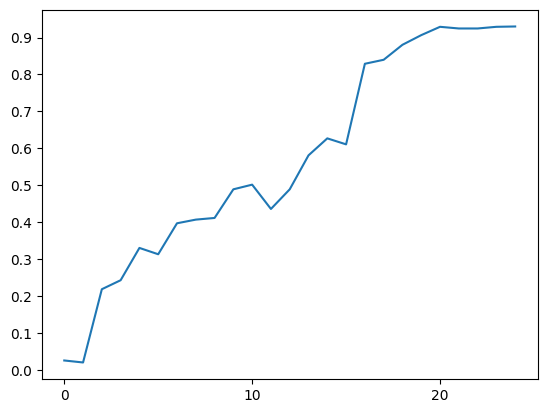

Doing for:  30 10
model uploaded
Epoch: 0, 	Accuracy: 0.07598936650448915, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.10141947133470432, 	Test accuracy: 0.021602160216021602
Epoch: 2, 	Accuracy: 0.1062346391132066, 	Test accuracy: 0.09450945094509451
Epoch: 3, 	Accuracy: 0.10182073531624618, 	Test accuracy: 0.2223222322232223
Epoch: 4, 	Accuracy: 0.1302603200080253, 	Test accuracy: 0.2295229522952295
Epoch: 5, 	Accuracy: 0.1790138937653609, 	Test accuracy: 0.2889288928892889
Epoch: 6, 	Accuracy: 0.23102773737272408, 	Test accuracy: 0.27542754275427545
Epoch: 7, 	Accuracy: 0.2710036615338316, 	Test accuracy: 0.279027902790279
Epoch: 8, 	Accuracy: 0.3108792696995536, 	Test accuracy: 0.279027902790279
Epoch: 9, 	Accuracy: 0.3279329889150825, 	Test accuracy: 0.28622862286228623
Epoch: 10, 	Accuracy: 0.3691628630185083, 	Test accuracy: 0.35553555355535554
Epoch: 11, 	Accuracy: 0.41686311882429655, 	Test accuracy: 0.42664266426642666
Epoch: 12, 	Accuracy: 0.46702111651702866, 

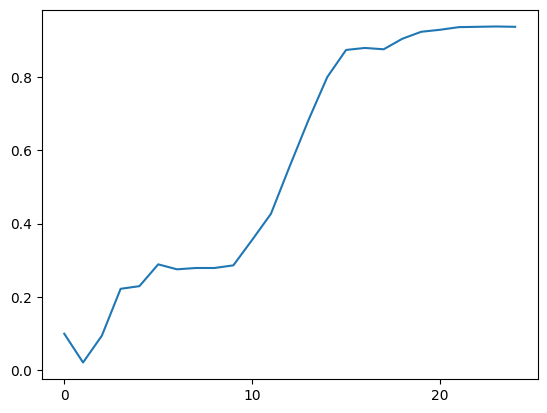

Doing for:  30 6
model uploaded
Epoch: 0, 	Accuracy: 0.08250990620454432, 	Test accuracy: 0.045004500450045004
Epoch: 1, 	Accuracy: 0.12489341425490294, 	Test accuracy: 0.0999099909990999
Epoch: 2, 	Accuracy: 0.12519436224105934, 	Test accuracy: 0.15391539153915393
Epoch: 3, 	Accuracy: 0.17916436775843908, 	Test accuracy: 0.21152115211521152
Epoch: 4, 	Accuracy: 0.19862567086321914, 	Test accuracy: 0.26552655265526554
Epoch: 5, 	Accuracy: 0.2856999548578021, 	Test accuracy: 0.21782178217821782
Epoch: 6, 	Accuracy: 0.34303054622059487, 	Test accuracy: 0.5211521152115212
Epoch: 7, 	Accuracy: 0.40848673320961026, 	Test accuracy: 0.6147614761476148
Epoch: 8, 	Accuracy: 0.48873952951798166, 	Test accuracy: 0.6381638163816382
Epoch: 9, 	Accuracy: 0.5435622209961378, 	Test accuracy: 0.8127812781278128
Epoch: 10, 	Accuracy: 0.5819330892310779, 	Test accuracy: 0.6984698469846985
Epoch: 11, 	Accuracy: 0.6399157345638762, 	Test accuracy: 0.8838883888388839
Epoch: 12, 	Accuracy: 0.684706826503486,

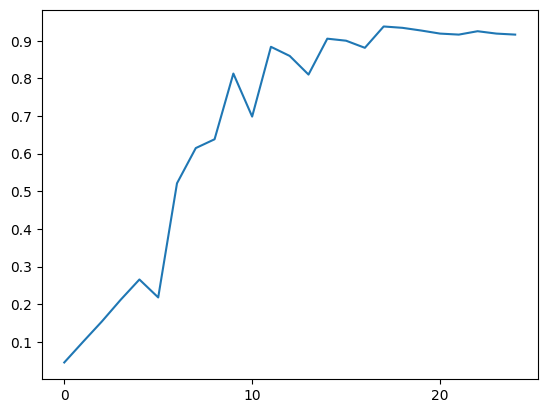

Doing for:  30 3
model uploaded
Epoch: 0, 	Accuracy: 0.08085469228068415, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.13005968801725434, 	Test accuracy: 0.1323132313231323
Epoch: 2, 	Accuracy: 0.18317700757385766, 	Test accuracy: 0.13861386138613863
Epoch: 3, 	Accuracy: 0.24988714450519137, 	Test accuracy: 0.2502250225022502
Epoch: 4, 	Accuracy: 0.3070171038772132, 	Test accuracy: 0.4158415841584158
Epoch: 5, 	Accuracy: 0.35170787982143753, 	Test accuracy: 0.5148514851485149
Epoch: 6, 	Accuracy: 0.3974519737172092, 	Test accuracy: 0.5814581458145814
Epoch: 7, 	Accuracy: 0.47935998394944074, 	Test accuracy: 0.8118811881188119
Epoch: 8, 	Accuracy: 0.5660330039624818, 	Test accuracy: 0.8370837083708371
Epoch: 9, 	Accuracy: 0.6355018307669158, 	Test accuracy: 0.7893789378937894
Epoch: 10, 	Accuracy: 0.6933340021066359, 	Test accuracy: 0.882988298829883
Epoch: 11, 	Accuracy: 0.75472739128254, 	Test accuracy: 0.9090909090909091
Epoch: 12, 	Accuracy: 0.7980639012890606, 	Test 

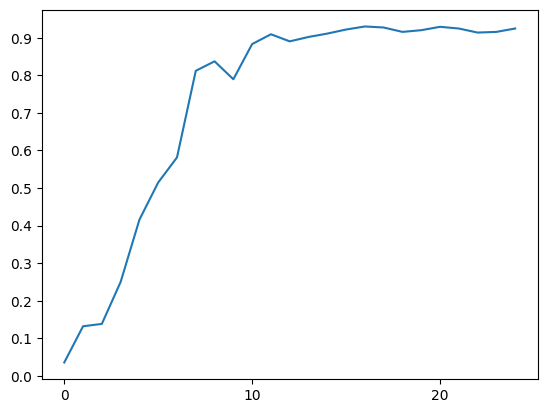

Doing for:  30 1
model uploaded
Epoch: 0, 	Accuracy: 0.07057230275367407, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.12193409239103176, 	Test accuracy: 0.0369036903690369
Epoch: 2, 	Accuracy: 0.1743491999799368, 	Test accuracy: 0.09180918091809182
Epoch: 3, 	Accuracy: 0.1932587651100968, 	Test accuracy: 0.2151215121512151
Epoch: 4, 	Accuracy: 0.2751667753423283, 	Test accuracy: 0.24392439243924394
Epoch: 5, 	Accuracy: 0.3164969654411396, 	Test accuracy: 0.31053105310531054
Epoch: 6, 	Accuracy: 0.35832873551687816, 	Test accuracy: 0.3069306930693069
Epoch: 7, 	Accuracy: 0.3780909866078146, 	Test accuracy: 0.37983798379837985
Epoch: 8, 	Accuracy: 0.4188694387320058, 	Test accuracy: 0.6021602160216022
Epoch: 9, 	Accuracy: 0.486983999598736, 	Test accuracy: 0.7344734473447345
Epoch: 10, 	Accuracy: 0.5620203641470632, 	Test accuracy: 0.7623762376237624
Epoch: 11, 	Accuracy: 0.6448813763354567, 	Test accuracy: 0.8424842484248425
Epoch: 12, 	Accuracy: 0.7059236595275117, 	Test 

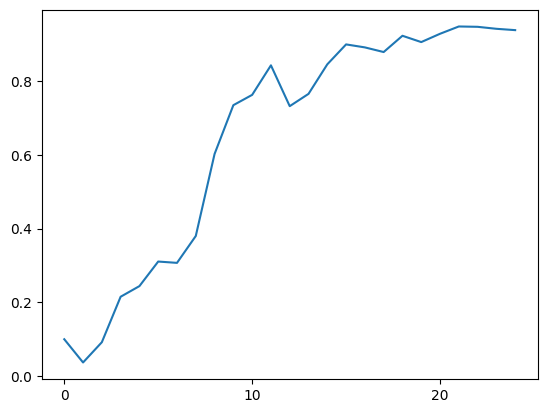

Doing for:  20 15
model uploaded
Epoch: 0, 	Accuracy: 0.06625871495209912, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.09755730551236394, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.1148116567186638, 	Test accuracy: 0.036003600360036005
Epoch: 3, 	Accuracy: 0.1255956262226012, 	Test accuracy: 0.036003600360036005
Epoch: 6, 	Accuracy: 0.17284446004915482, 	Test accuracy: 0.28802880288028804
Epoch: 7, 	Accuracy: 0.21858855394492652, 	Test accuracy: 0.28802880288028804
Epoch: 8, 	Accuracy: 0.2738626674023173, 	Test accuracy: 0.36363636363636365
Epoch: 9, 	Accuracy: 0.34022169834980187, 	Test accuracy: 0.40324032403240323
Epoch: 10, 	Accuracy: 0.4012138235441641, 	Test accuracy: 0.5076507650765076
Epoch: 11, 	Accuracy: 0.447108391433014, 	Test accuracy: 0.5481548154815482
Epoch: 12, 	Accuracy: 0.49957365701961176, 	Test accuracy: 0.5697569756975698
Epoch: 13, 	Accuracy: 0.5424587450468977, 	Test accuracy: 0.5877587758775877
Epoch: 14, 	Accuracy: 0.582986407182

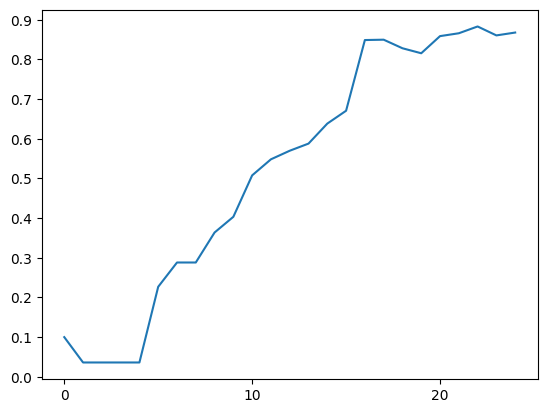

Doing for:  20 10
model uploaded
Epoch: 0, 	Accuracy: 0.06961930079751216, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.10768922104629583, 	Test accuracy: 0.07650765076507651
Epoch: 2, 	Accuracy: 0.09033455384461052, 	Test accuracy: 0.09720972097209721
Epoch: 3, 	Accuracy: 0.12679941816722676, 	Test accuracy: 0.1269126912691269
Epoch: 4, 	Accuracy: 0.1762050458945679, 	Test accuracy: 0.10621062106210621
Epoch: 5, 	Accuracy: 0.20223704669709586, 	Test accuracy: 0.13771377137713772
Epoch: 6, 	Accuracy: 0.2330842152781261, 	Test accuracy: 0.28982898289828984
Epoch: 7, 	Accuracy: 0.2794302051462106, 	Test accuracy: 0.2304230423042304
Epoch: 8, 	Accuracy: 0.3087224757987661, 	Test accuracy: 0.33663366336633666
Epoch: 9, 	Accuracy: 0.3494507699252646, 	Test accuracy: 0.41224122412241226
Epoch: 10, 	Accuracy: 0.4025680894818679, 	Test accuracy: 0.48334833483348333
Epoch: 11, 	Accuracy: 0.47173596830014547, 	Test accuracy: 0.47794779477947796
Epoch: 12, 	Accuracy: 0.521342228018

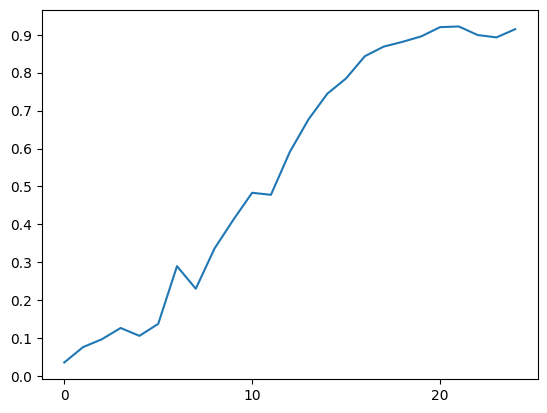

Doing for:  20 6
model uploaded
Epoch: 0, 	Accuracy: 0.07318051863369614, 	Test accuracy: 0.048604860486048604
Epoch: 1, 	Accuracy: 0.11155138686863621, 	Test accuracy: 0.0999099909990999
Epoch: 2, 	Accuracy: 0.15769674474594975, 	Test accuracy: 0.20612061206120613
Epoch: 3, 	Accuracy: 0.23659527511661735, 	Test accuracy: 0.40684068406840684
Epoch: 4, 	Accuracy: 0.33861664242363443, 	Test accuracy: 0.39603960396039606
Epoch: 5, 	Accuracy: 0.43522094597983646, 	Test accuracy: 0.5283528352835284
Epoch: 6, 	Accuracy: 0.4749460801524803, 	Test accuracy: 0.6300630063006301
Epoch: 7, 	Accuracy: 0.5473742288207855, 	Test accuracy: 0.6975697569756976
Epoch: 8, 	Accuracy: 0.6182976375583087, 	Test accuracy: 0.8334833483348335
Epoch: 9, 	Accuracy: 0.6915784721873903, 	Test accuracy: 0.8442844284428442
Epoch: 10, 	Accuracy: 0.7485077995686412, 	Test accuracy: 0.8748874887488749
Epoch: 11, 	Accuracy: 0.7912925716005417, 	Test accuracy: 0.9027902790279028
Epoch: 12, 	Accuracy: 0.8328233936901239, 	

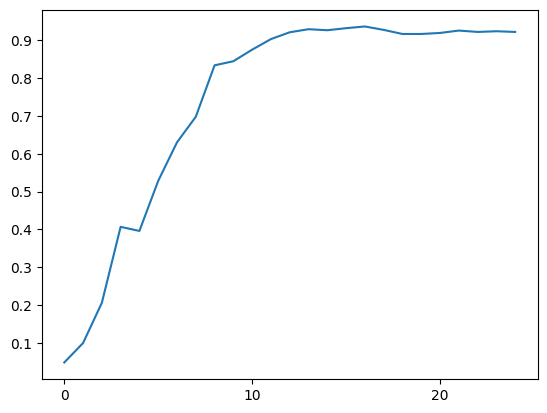

Doing for:  20 3
model uploaded
Epoch: 0, 	Accuracy: 0.07553794452525456, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.12995937202186889, 	Test accuracy: 0.12061206120612061
Epoch: 2, 	Accuracy: 0.16506997040678137, 	Test accuracy: 0.2583258325832583
Epoch: 3, 	Accuracy: 0.2221497717811105, 	Test accuracy: 0.27542754275427545
Epoch: 4, 	Accuracy: 0.25219441239905704, 	Test accuracy: 0.42754275427542754
Epoch: 5, 	Accuracy: 0.3362090585343833, 	Test accuracy: 0.49054905490549056
Epoch: 6, 	Accuracy: 0.4051261473641972, 	Test accuracy: 0.5625562556255626
Epoch: 7, 	Accuracy: 0.4370266338967748, 	Test accuracy: 0.6867686768676867
Epoch: 8, 	Accuracy: 0.49591212318804234, 	Test accuracy: 0.7920792079207921
Epoch: 9, 	Accuracy: 0.5674374278978783, 	Test accuracy: 0.7722772277227723
Epoch: 10, 	Accuracy: 0.6319907709284245, 	Test accuracy: 0.7191719171917191
Epoch: 11, 	Accuracy: 0.6814465566534584, 	Test accuracy: 0.8487848784878488
Epoch: 12, 	Accuracy: 0.7352159301800673, 	Te

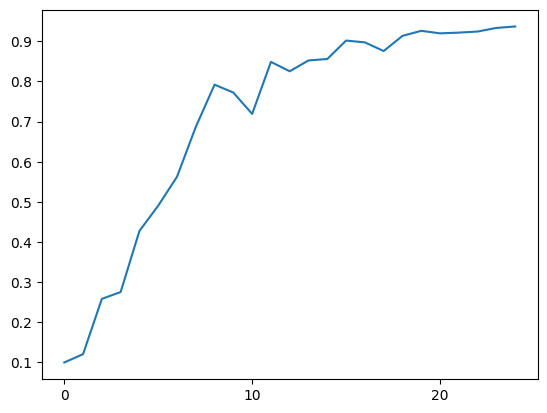

Doing for:  20 1
model uploaded
Epoch: 0, 	Accuracy: 0.06540602899132267, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.12599689020414306, 	Test accuracy: 0.126012601260126
Epoch: 2, 	Accuracy: 0.1710387721322165, 	Test accuracy: 0.13141314131413143
Epoch: 3, 	Accuracy: 0.21773586798415007, 	Test accuracy: 0.15391539153915393
Epoch: 4, 	Accuracy: 0.27657119927772483, 	Test accuracy: 0.1548154815481548
Epoch: 5, 	Accuracy: 0.334955108592065, 	Test accuracy: 0.43474347434743477
Epoch: 6, 	Accuracy: 0.4159602748658274, 	Test accuracy: 0.5994599459945995
Epoch: 7, 	Accuracy: 0.4925515373426293, 	Test accuracy: 0.6687668766876688
Epoch: 8, 	Accuracy: 0.5669860059186437, 	Test accuracy: 0.6750675067506751
Epoch: 9, 	Accuracy: 0.6203541154637107, 	Test accuracy: 0.7596759675967597
Epoch: 10, 	Accuracy: 0.6609319355971309, 	Test accuracy: 0.8631863186318632
Epoch: 11, 	Accuracy: 0.7379244620554748, 	Test accuracy: 0.8847884788478848
Epoch: 12, 	Accuracy: 0.7860761398404975, 	Test a

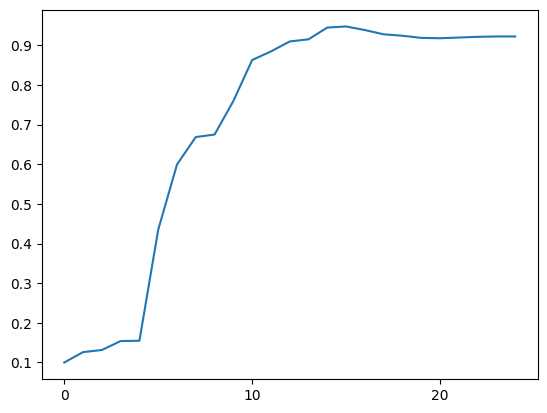

Doing for:  15 10
model uploaded
Epoch: 0, 	Accuracy: 0.07784521241912024, 	Test accuracy: 0.021602160216021602
Epoch: 1, 	Accuracy: 0.09710588353312936, 	Test accuracy: 0.0783078307830783
Epoch: 2, 	Accuracy: 0.09309324371771079, 	Test accuracy: 0.036003600360036005
Epoch: 3, 	Accuracy: 0.1323167979134273, 	Test accuracy: 0.0576057605760576
Epoch: 4, 	Accuracy: 0.1596529066559663, 	Test accuracy: 0.10531053105310531
Epoch: 5, 	Accuracy: 0.20509605256558158, 	Test accuracy: 0.18181818181818182
Epoch: 6, 	Accuracy: 0.25500326026985004, 	Test accuracy: 0.23132313231323132
Epoch: 7, 	Accuracy: 0.30195114611024726, 	Test accuracy: 0.30063006300630063
Epoch: 8, 	Accuracy: 0.35983347544766014, 	Test accuracy: 0.3771377137713771
Epoch: 9, 	Accuracy: 0.4066308872949792, 	Test accuracy: 0.6858685868586859
Epoch: 10, 	Accuracy: 0.45613683101770575, 	Test accuracy: 0.7218721872187218
Epoch: 11, 	Accuracy: 0.5140191603551186, 	Test accuracy: 0.7515751575157515
Epoch: 12, 	Accuracy: 0.5752620755379

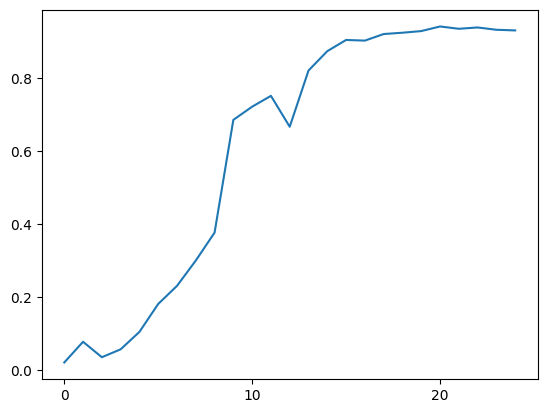

Doing for:  15 6
model uploaded
Epoch: 0, 	Accuracy: 0.07995184832221498, 	Test accuracy: 0.10171017101710171
Epoch: 1, 	Accuracy: 0.1143602347394292, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.15142699503435822, 	Test accuracy: 0.1332133213321332
Epoch: 3, 	Accuracy: 0.18759091137081807, 	Test accuracy: 0.1926192619261926
Epoch: 4, 	Accuracy: 0.28208857902392537, 	Test accuracy: 0.3213321332133213
Epoch: 5, 	Accuracy: 0.399558609620304, 	Test accuracy: 0.41944194419441944
Epoch: 6, 	Accuracy: 0.513768370366655, 	Test accuracy: 0.6966696669666966
Epoch: 7, 	Accuracy: 0.6050057681697346, 	Test accuracy: 0.7281728172817282
Epoch: 8, 	Accuracy: 0.6838039825450168, 	Test accuracy: 0.8937893789378938
Epoch: 9, 	Accuracy: 0.753423283342529, 	Test accuracy: 0.9063906390639064
Epoch: 10, 	Accuracy: 0.8020765411044791, 	Test accuracy: 0.9063906390639064
Epoch: 11, 	Accuracy: 0.8463660530671615, 	Test accuracy: 0.9270927092709271
Epoch: 12, 	Accuracy: 0.8715453679089131, 	Test a

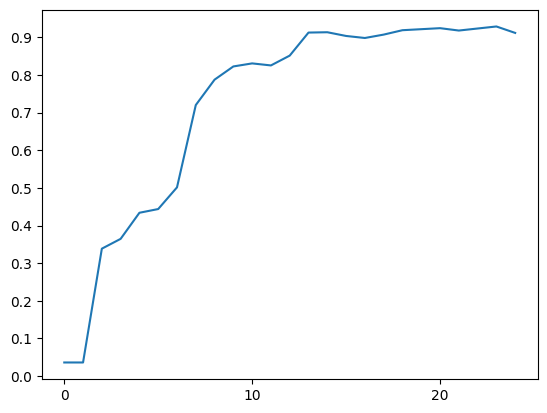

Doing for:  15 1
model uploaded
Epoch: 0, 	Accuracy: 0.09158850378692883, 	Test accuracy: 0.0999099909990999
Epoch: 1, 	Accuracy: 0.1062346391132066, 	Test accuracy: 0.1278127812781278
Epoch: 2, 	Accuracy: 0.168881978231429, 	Test accuracy: 0.10801080108010801
Epoch: 3, 	Accuracy: 0.206701108491749, 	Test accuracy: 0.25292529252925294
Epoch: 4, 	Accuracy: 0.32537493103275317, 	Test accuracy: 0.46534653465346537
Epoch: 5, 	Accuracy: 0.4148567989165873, 	Test accuracy: 0.46894689468946893
Epoch: 6, 	Accuracy: 0.45458193308923106, 	Test accuracy: 0.49324932493249324
Epoch: 7, 	Accuracy: 0.5154737422882079, 	Test accuracy: 0.6903690369036903
Epoch: 8, 	Accuracy: 0.5838390931434018, 	Test accuracy: 0.7398739873987399
Epoch: 9, 	Accuracy: 0.627777499122235, 	Test accuracy: 0.7938793879387939
Epoch: 10, 	Accuracy: 0.6797411847319055, 	Test accuracy: 0.8397839783978398
Epoch: 11, 	Accuracy: 0.7324572403069669, 	Test accuracy: 0.873987398739874
Epoch: 12, 	Accuracy: 0.7721823744796108, 	Test ac

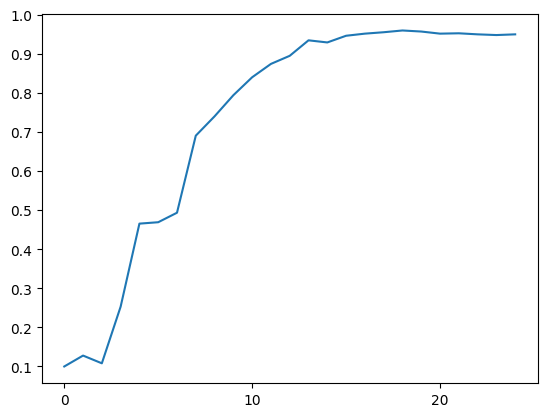

Doing for:  10 6
model uploaded
Epoch: 0, 	Accuracy: 0.07624015649295281, 	Test accuracy: 0.036003600360036005
Epoch: 1, 	Accuracy: 0.13602848974268947, 	Test accuracy: 0.2232223222322232
Epoch: 2, 	Accuracy: 0.1921552891608567, 	Test accuracy: 0.2376237623762376
Epoch: 3, 	Accuracy: 0.23659527511661735, 	Test accuracy: 0.3321332133213321
Epoch: 4, 	Accuracy: 0.2753172493354065, 	Test accuracy: 0.48874887488748875
Epoch: 5, 	Accuracy: 0.33013994081356274, 	Test accuracy: 0.6111611161116112
Epoch: 6, 	Accuracy: 0.41856849074584945, 	Test accuracy: 0.6876687668766877
Epoch: 7, 	Accuracy: 0.5100566785373928, 	Test accuracy: 0.7191719171917191
Epoch: 8, 	Accuracy: 0.5716506997040678, 	Test accuracy: 0.7938793879387939
Epoch: 9, 	Accuracy: 0.6493955961278026, 	Test accuracy: 0.8037803780378038
Epoch: 10, 	Accuracy: 0.7064753975021317, 	Test accuracy: 0.8451845184518452
Epoch: 11, 	Accuracy: 0.7666148367357175, 	Test accuracy: 0.9108910891089109
Epoch: 12, 	Accuracy: 0.804333651000652, 	Test

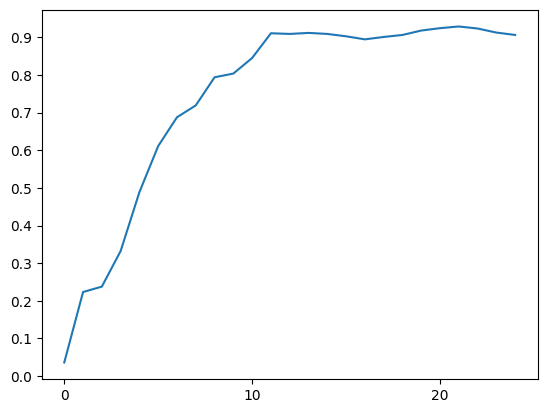

Doing for:  10 3
model uploaded
Epoch: 0, 	Accuracy: 0.06976977479059036, 	Test accuracy: 0.10711071107110712
Epoch: 1, 	Accuracy: 0.12805336810954507, 	Test accuracy: 0.09810981098109811
Epoch: 2, 	Accuracy: 0.17876310377689722, 	Test accuracy: 0.12961296129612962
Epoch: 3, 	Accuracy: 0.23137884335657322, 	Test accuracy: 0.22052205220522053
Epoch: 4, 	Accuracy: 0.32843456889200984, 	Test accuracy: 0.27002700270027
Epoch: 5, 	Accuracy: 0.3936901238902543, 	Test accuracy: 0.3321332133213321
Epoch: 6, 	Accuracy: 0.45578572503385667, 	Test accuracy: 0.6237623762376238
Epoch: 10, 	Accuracy: 0.7276420725284647, 	Test accuracy: 0.8100810081008101
Epoch: 11, 	Accuracy: 0.76390630486031, 	Test accuracy: 0.8334833483348335
Epoch: 12, 	Accuracy: 0.7915935195866981, 	Test accuracy: 0.8154815481548154
Epoch: 13, 	Accuracy: 0.8168229924261423, 	Test accuracy: 0.9054905490549054
Epoch: 14, 	Accuracy: 0.8565982845964789, 	Test accuracy: 0.9261926192619262
Epoch: 15, 	Accuracy: 0.8823293374128505, 	Te

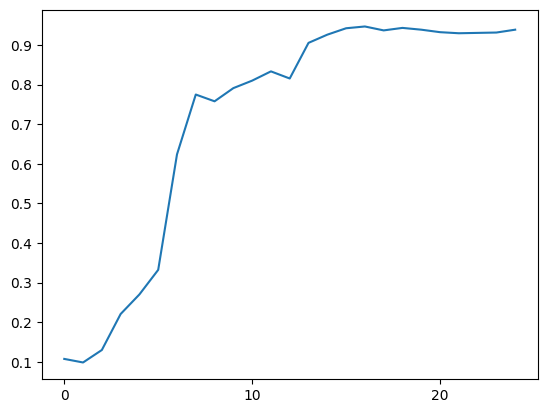

Doing for:  10 1
model uploaded
Epoch: 0, 	Accuracy: 0.07067261874905954, 	Test accuracy: 0.09720972097209721
Epoch: 1, 	Accuracy: 0.12850479008877966, 	Test accuracy: 0.036003600360036005
Epoch: 2, 	Accuracy: 0.15599137282439685, 	Test accuracy: 0.0576057605760576
Epoch: 3, 	Accuracy: 0.21287054220795507, 	Test accuracy: 0.17461746174617462
Epoch: 4, 	Accuracy: 0.2693484476099714, 	Test accuracy: 0.14401440144014402
Epoch: 5, 	Accuracy: 0.33229673471435023, 	Test accuracy: 0.22142214221422143
Epoch: 6, 	Accuracy: 0.38842353413251746, 	Test accuracy: 0.2925292529252925
Epoch: 7, 	Accuracy: 0.4391834277975623, 	Test accuracy: 0.44104410441044106
Epoch: 8, 	Accuracy: 0.48106535587099364, 	Test accuracy: 0.45814581458145814
Epoch: 9, 	Accuracy: 0.5429603250238251, 	Test accuracy: 0.6921692169216922
Epoch: 10, 	Accuracy: 0.6358529367507649, 	Test accuracy: 0.7065706570657065
Epoch: 11, 	Accuracy: 0.6690073732256608, 	Test accuracy: 0.8037803780378038
Epoch: 12, 	Accuracy: 0.718814264934543

In [ ]:
for k1 in [30, 20, 15, 10, 5, 2]:
    for k2 in [15, 10, 6, 3, 1]:
        if k1 > k2:
            print("Doing for: ", k1, k2)
            train_fun(k1, k2, 0.009)